<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [0]:
import cv2 as cv
import pandas as pd
import numpy as np
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!wget https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/common.py -O "common.py"
from common import *

--2020-01-15 18:06:31--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/common.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4100 (4.0K) [text/plain]
Saving to: ‘common.py’

common.py           100%[===================>]   4.00K  --.-KB/s    in 0s      

2020-01-15 18:06:32 (81.4 MB/s) - ‘common.py’ saved [4100/4100]



In [10]:
!wget https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/detection.py -O "detection.py"
from detection import *

--2020-01-15 18:08:03--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/detection.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2755 (2.7K) [text/plain]
Saving to: ‘detection.py’

detection.py        100%[===================>]   2.69K  --.-KB/s    in 0s      

2020-01-15 18:08:03 (16.0 MB/s) - ‘detection.py’ saved [2755/2755]



In [5]:
!cp "./drive/My Drive/sudoku_acquisition_output.bz2" "./sudoku_acquisition_output.bz2"
dataset = pd.read_pickle("./sudoku_acquisition_output.bz2")
dataset

,input_image,input_digits,input_classes,training
input_filename,,,,
./v2_train/image169.jpg,"[[[164, 161, 118], [164, 161, 118], [164, 161,...","[[8, 3, 0, 0, 0, 7, 9, 0, 0], [0, 0, 0, 0, 3, ...","[[1, 1, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 1, ...",False
./v2_train/image72.jpg,"[[[169, 168, 147], [169, 168, 147], [169, 168,...","[[0, 7, 1, 9, 0, 2, 0, 5, 0], [0, 0, 0, 0, 0, ...","[[0, 1, 1, 1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, ...",True
./v2_train/image1066.jpg,"[[[146, 143, 147], [146, 143, 147], [147, 145,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 6, 0, 1, 5, ...","[[1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 1, ...",False
./v2_train/image1087.jpg,"[[[47, 42, 43], [48, 44, 41], [46, 45, 42], [4...","[[0, 0, 2, 0, 0, 9, 1, 0, 5], [0, 8, 0, 7, 0, ...","[[0, 0, 1, 0, 0, 1, 1, 0, 1], [0, 1, 0, 1, 0, ...",True
./v2_train/image204.jpg,"[[[154, 146, 93], [158, 150, 103], [163, 154, ...","[[0, 1, 3, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 4, ...","[[0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, ...",False
...,...,...,...,...
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165358878.jpg,"[[[77, 75, 78], [77, 75, 78], [78, 76, 79], [7...","[[2, 4, 7, 9, 9, 4, 7, 6, 1], [8, 7, 6, 2, 6, ...","[[2, 2, 2, 2, 2, 2, 1, 2, 1], [1, 2, 2, 2, 2, ...",True
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165329872.jpg,"[[[133, 127, 105], [132, 126, 104], [133, 127,...","[[2, 4, 7, 9, 9, 4, 7, 6, 1], [8, 7, 6, 2, 6, ...","[[2, 2, 2, 2, 2, 2, 1, 2, 1], [1, 2, 2, 2, 2, ...",True
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165402379.jpg,"[[[51, 51, 51], [49, 49, 49], [46, 46, 46], [4...","[[2, 4, 7, 9, 9, 4, 7, 6, 1], [8, 7, 6, 2, 6, ...","[[2, 2, 2, 2, 2, 2, 1, 2, 1], [1, 2, 2, 2, 2, ...",True


# Introduction

We previously imported and built our input dataset.
From here on our first step is to detect the Sudoku grid within each input image.
The goal here is to find the four points that define the corners of an Sudoku puzzle.

Along each step in this notebook the current state of our analysis is regulary visualized.
As there are many different images, we randomly choose *4* exemplary images for use throughout this notebook and store their respective indices in the `demo_indices` variable.

In [6]:
demo_indices = np.random.permutation(len(dataset.index))[:4]
demo_indices

array([310, 341, 358, 182])

These indices map to the following input filenames:

In [17]:
dataset.index[demo_indices]

Index(['./sudoku_dataset_1024/train_247994761_empty/IMG_8773.JPG',
       './sudoku_dataset_1024/train_234598176_full/IMG_8880.JPG',
       './sudoku_dataset_1024/test_324823921_empty/IMG_8745.JPG',
       './sudoku_dataset_1024/test_149567823_empty/IMG_8812.JPG'],
      dtype='object', name='input_filename')

# Preprocessing

Before we can apply our actual "Sudoku detection algorithm" we have to preprocess the input images.
We plan on using the method `findContours(...)` provided by OpenCV which only accepts binary images where each pixel is either *completely black* or *completely white* with no gray values inbetween.

## Grayscale conversion

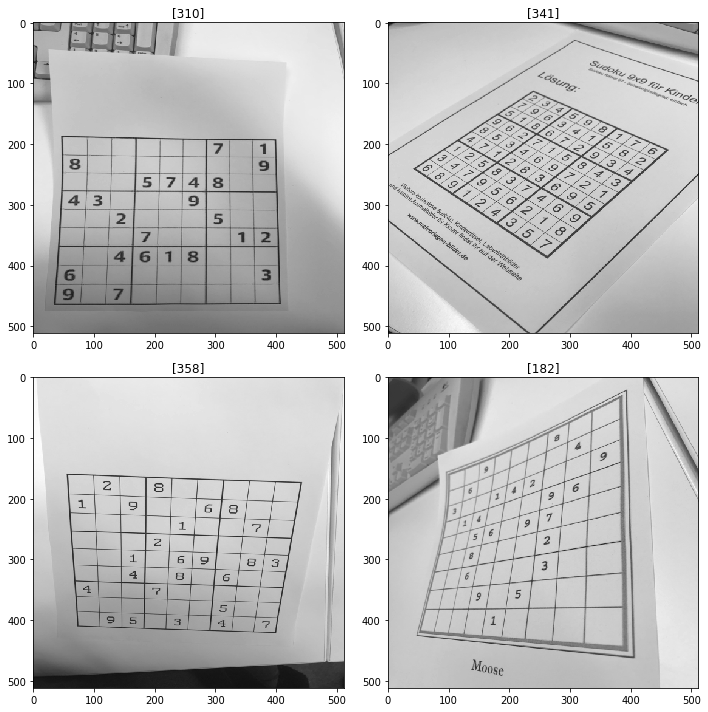

In [16]:
dataset["gray_image"] = [convert_to_grayscale(x, "RGB") for x in dataset["input_image"]]
show_images(dataset["gray_image"], cmap="gray", i_samples=demo_indices)

## Thresholding

Grayscale images only have one "color" channel, but this one is still not binary.
For this reason we use thresholding, which maps values below some threshold $x$ to "completely black" and values above $x$ to "completely white".
More precisely we use a technique called "adaptive thresholding" which requires us to define a "block size".
The method `adaptiveThreshold(...)` from OpenCV requires the block size to be specified by a number of pixels.
Because we accept different kinds of images with varying resolutions, we define it relative to the image resolution and then convert to an absolute number of pixels as required.


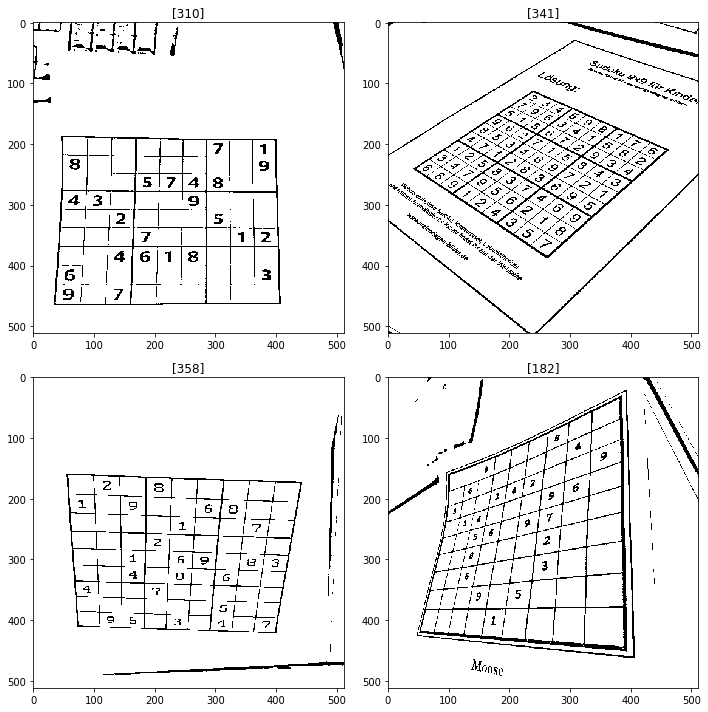

In [18]:
#@title Configuration { run: "auto" }
default_threshold_block_size = 0.1 #@param { type: "slider", min: 0, max: 1, step: 0.1 }
default_threshold_bias = 32 #@param { type:"slider", min: -255, max: 255, step: 1 }

dataset["thresh_image"] = [threshold_image(x, block_size=default_threshold_block_size, bias=default_threshold_bias) for x in dataset["gray_image"]]
show_images(dataset["thresh_image"], cmap="gray", i_samples=demo_indices)

# Contour Detection
Finally we can try to detect the shape of a Sudoku grid within each image.
As previously mentioned we do this using the method `findContours(...)` provided by OpenCV.
We wrote a custom wrapper [`find_contours(...)`](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/detection.py) around this method that also inverts the image.
This is necessary as OpenCV interprets black pixels as background and white pixels as foreground.
However we assume that Sudoku puzzles in general are "black-on-white" images where (in this sense) background and foreground are reversed.
This would cause OpenCV to sometimes find a contour alongside the whole image border that interferes with our analysis.  

In [15]:
dataset["contours"] = [find_contours(x) for x in dataset["thresh_image"]]
dataset["contours"]

input_filename
./v2_train/image169.jpg                                                  [[[[511 401]]], [[[380 122]], [[379 123]], [[3...
./v2_train/image72.jpg                                                   [[[[424 484]], [[424 485]], [[425 485]]], [[[4...
./v2_train/image1066.jpg                                                 [[[[104 511]]], [[[ 60 511]]], [[[ 38 511]]], ...
./v2_train/image1087.jpg                                                 [[[[301 511]], [[302 511]]], [[[294 511]]], [[...
./v2_train/image204.jpg                                                  [[[[430 509]]], [[[420 508]], [[419 509]], [[4...
                                                                                               ...                        
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165358878.jpg    [[[[414 374]]], [[[408 374]]], [[[126 371]], [...
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165329872.jpg    [[[[332 152]], [[331 153]], [[201 153]], [[200...
.

The set of found contours can be visualized using the method `drawContours(...)` provided by OpenCV. For this method we also wrote a wrapper called [`draw_contours(...)`](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/detection.py) exposing a "nicer" interface for our use-case.

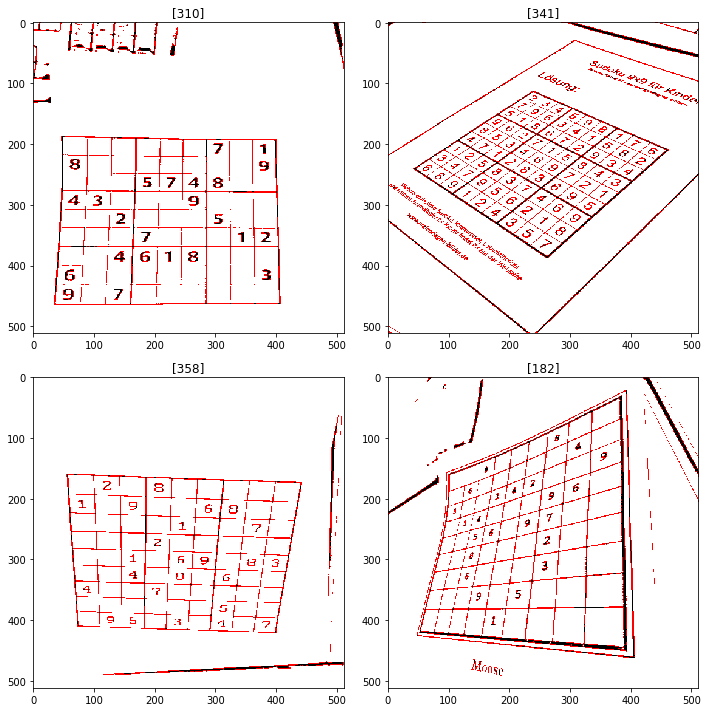

In [23]:
dataset["contours_image"] = [draw_contours(x, y, color=(255, 0, 0), input_format="GRAY", output_format="RGB") \
                            for x, y in zip(dataset["thresh_image"], dataset["contours"])]
show_images(dataset["contours_image"], i_samples=demo_indices)

# Contour Recognition

From all of the detected contours we now have to determine which contour is actually corresponding to the wanted Sudoku puzzle.

## Filtering four sided contours

**Assumption**: The Sudoku grid always has a square border.

**Idea:** A square has exactly four sides. Thus we can filter out all contours having less than or more than four sides.

The contours generated by `findContours(...)` can be very *wiggly* causing us to overestimate the actual number of sides.
To counter that, we approximate all contours using the method `approxPolyDP(...)` that is also provided by OpenCV.
Once again we wrote a custom wrapper [`approximate_contour(...)`](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/detection.py) where we can define the precision relative to the contour size instead of a fixed absolute value.

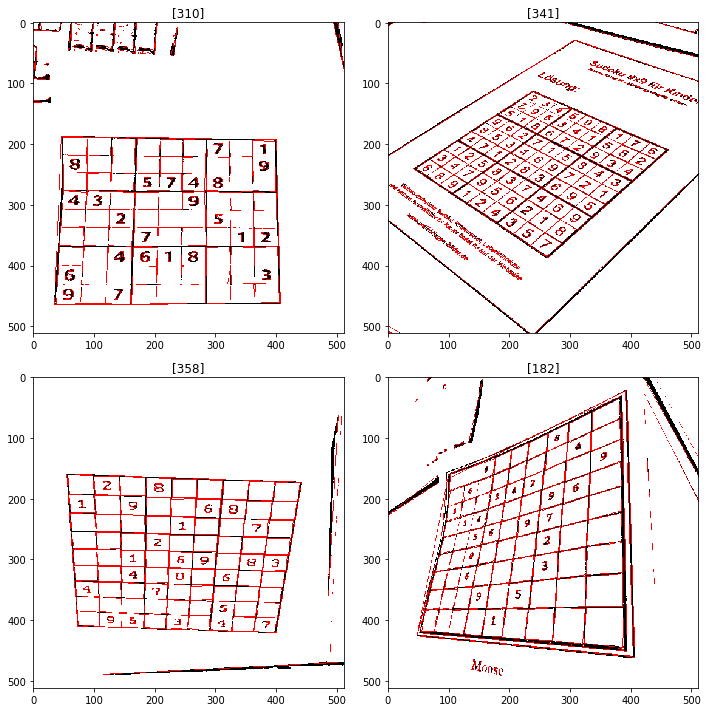

In [29]:
dataset["contours"] = [[approximate_contour(y) for y in x] for x in dataset["contours"]]
dataset["contours_image"] = [draw_contours(x, y, color=(255, 0, 0), input_format="GRAY", output_format="RGB") \
                             for x, y in zip(dataset["thresh_image"], dataset["contours"])]
show_images(dataset["contours_image"], i_samples=demo_indices)

Now we can actually filter out all contours that are not foursided using [`get_foursided_contours(...)`](`approximate_contour(...)`).

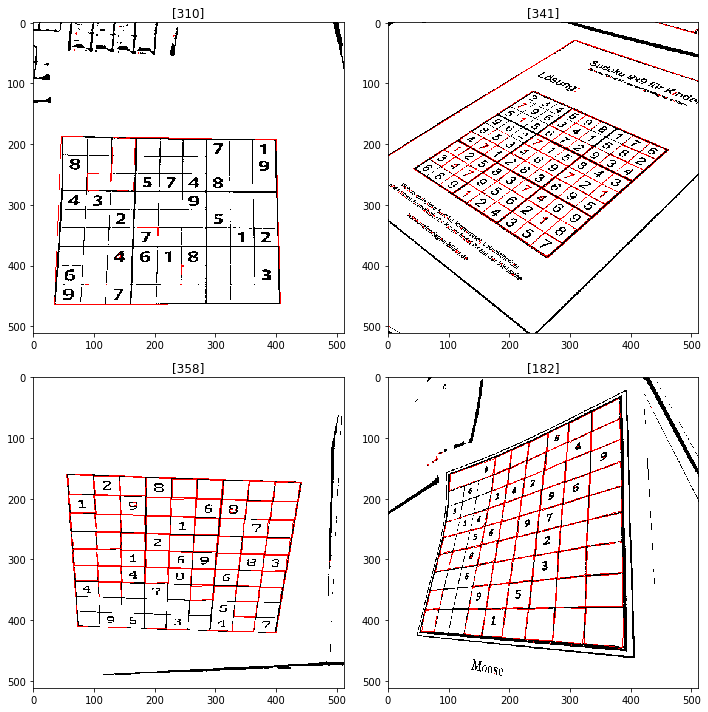

In [33]:
dataset["contours"] = [get_foursided_contours(x) for x in dataset["contours"]]
dataset["contour_image"] = [draw_contours(x, y, color=(255, 0, 0), input_format="GRAY", output_format="RGB") \
                            for x, y in zip(dataset["thresh_image"], dataset["contours"])]
show_images(dataset["contour_image"], i_samples=demo_indices)

But which of these foursided contours is our Sudoku square?

## Selecting largest contour

**Assumption:** The Sudoku grid is always the largest foursided object within all images.

**Idea:** Sort contours by area and choose the largest one.

Our method [`get_largest_contour(...)`](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/detection.py) returns the largest contour $c$ from a set of contours $C$ in relation to the area returned by OpenCV's `contourArea(...)` method respectively. If $C$ is empty, i. e. no foursided contours were found, it returns `None` instead. 

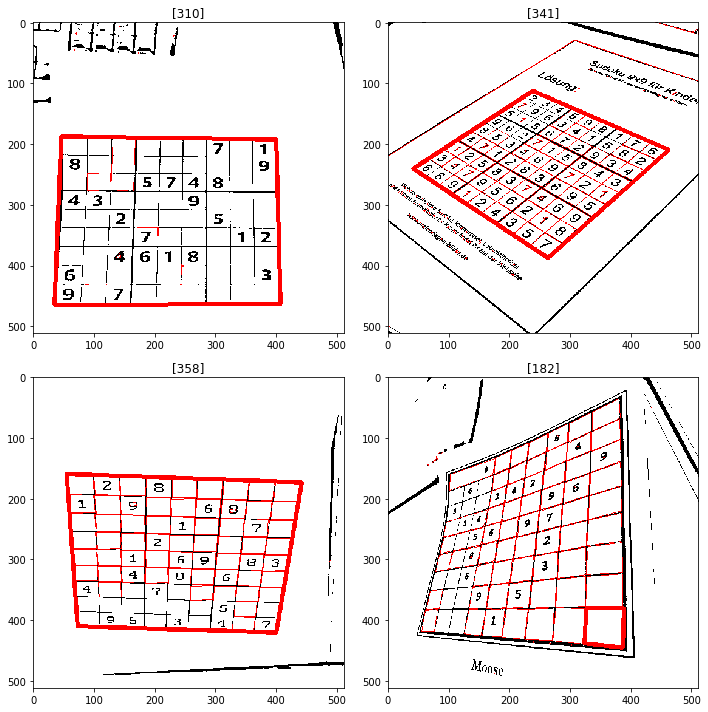

In [35]:
dataset["contour"] = [get_largest_contour(x) for x in dataset["contours"]]
dataset["contour_image"] = [draw_contours(x, [y], color=(255, 0, 0), thickness=0.01) \
                            for x, y in zip(dataset["contour_image"], dataset["contour"])]
show_images(dataset["contour_image"], i_samples=demo_indices)

## Sanity checks

The described process obviously is not perfect.
Sometimes it detects the wrong "square" or no Sudoku puzzle at all.
Reasons for this could be:

- Sudoku puzzle is not rectangular
- Sudoku puzzle has no clear uninterrupted border 
- Sudoku puzzle is not "black-on-white" colored
- Sudoku puzzle is not the largest rectangle in the image (e. g. the piece of paper itself has a block border)
- Any of the above issues caused by initial resizing or bad image quality in general

Sudokus that we could detect cannot be fed forward our "pipeline".
To filter out obvious "*mis*detections" we assume the following:

**Assumption**: Sudoku grid covers at least 10% of area within input image.

**Idea**: Filter out all contours that are smaller than this threshold.

This simple "sanity check" is implemented by [`check_sudoku_contour(...)`](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/detection.py).


In [38]:
dataset["contour_valid"] = [check_sudoku_contour(x, y) for x, y in zip(dataset["input_image"], dataset["contour"])]
dataset["contour_valid"]

input_filename
./v2_train/image169.jpg                                                  False
./v2_train/image72.jpg                                                   False
./v2_train/image1066.jpg                                                  True
./v2_train/image1087.jpg                                                  True
./v2_train/image204.jpg                                                   True
                                                                         ...  
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165358878.jpg    False
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165329872.jpg     True
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165402379.jpg     True
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165420778.jpg    False
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165333373.jpg     True
Name: contour_valid, Length: 452, dtype: bool

As per the return value we can split the dataset into a set of "possibly good" detections (stored in `dataset_good`) and "most probably bad" detections (stored in `dataset_bad`). 

In [39]:
dataset_good = dataset[dataset["contour_valid"] == True]
print("%d Sudoku grids detected!" % len(dataset_good))

dataset_bad = dataset[dataset["contour_valid"] == False]
print("%d Sudoku grids NOT detected!" % len(dataset_bad))

276 Sudoku grids detected!
176 Sudoku grids NOT detected!


# Examples of detected Sudoku grids

We assume that the following Sudoku puzzles were correctly detected.

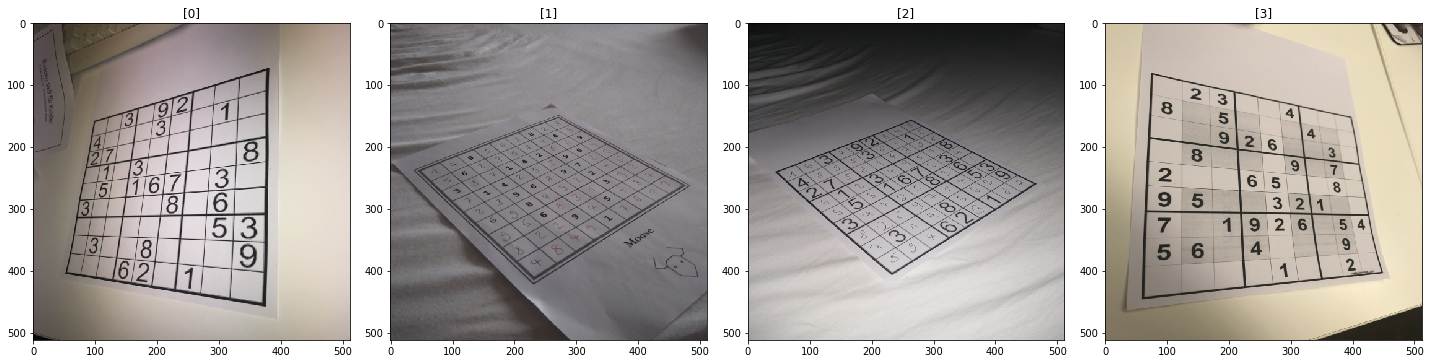

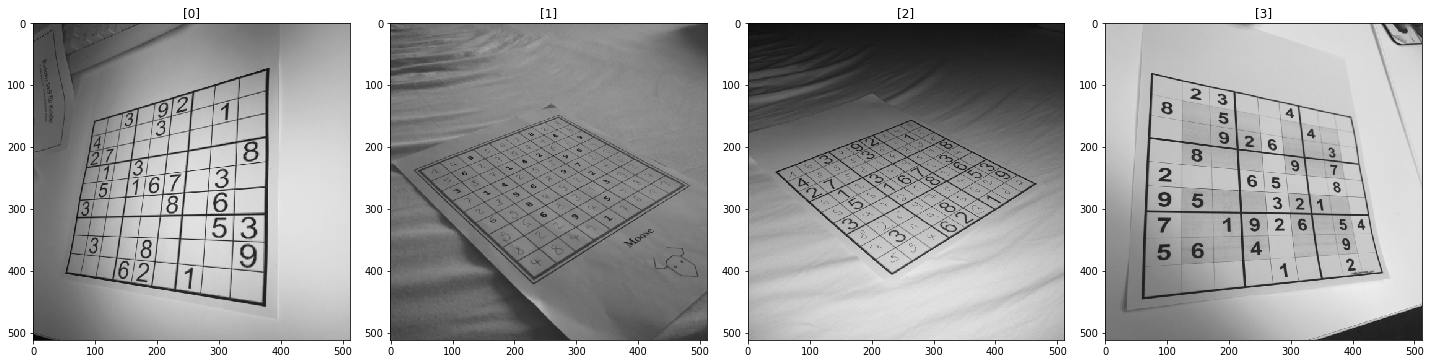

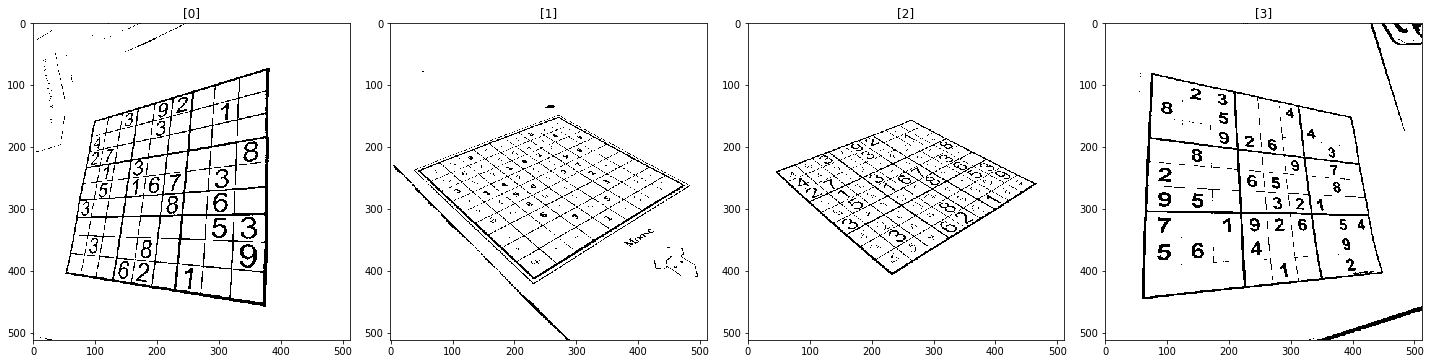

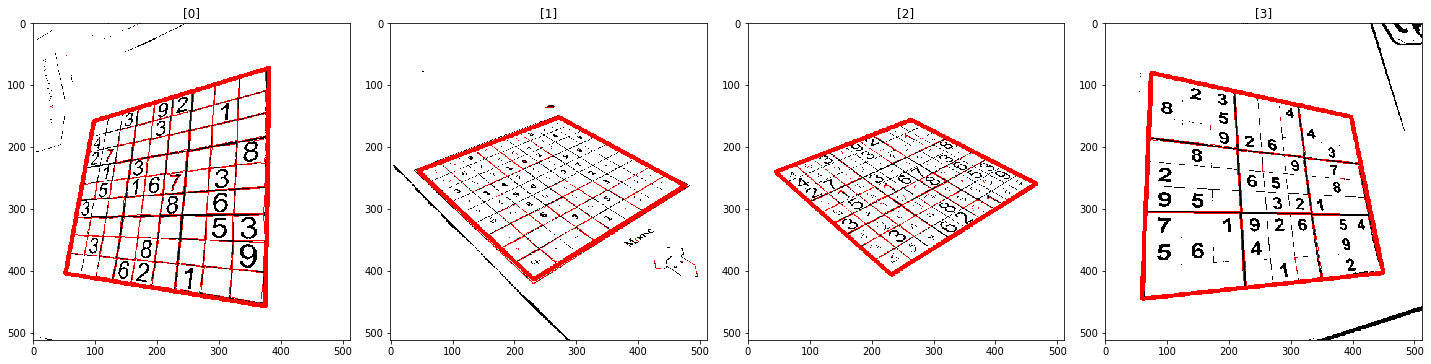

In [42]:
example_images = dataset_good.sample(n=4)
show_images(example_images["input_image"], rows=1)
show_images(example_images["gray_image"], cmap="gray", rows=1)
show_images(example_images["thresh_image"], cmap="gray", rows=1)
show_images(example_images["contour_image"], rows=1)

# Examples of undetected Sudoku grids

We assume that the following Sudoku puzzles were *not* correctly detected.

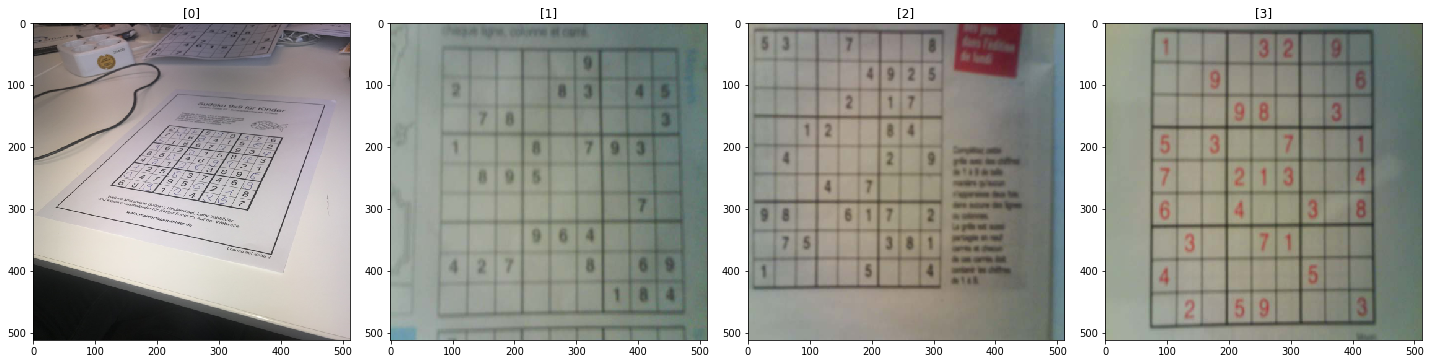

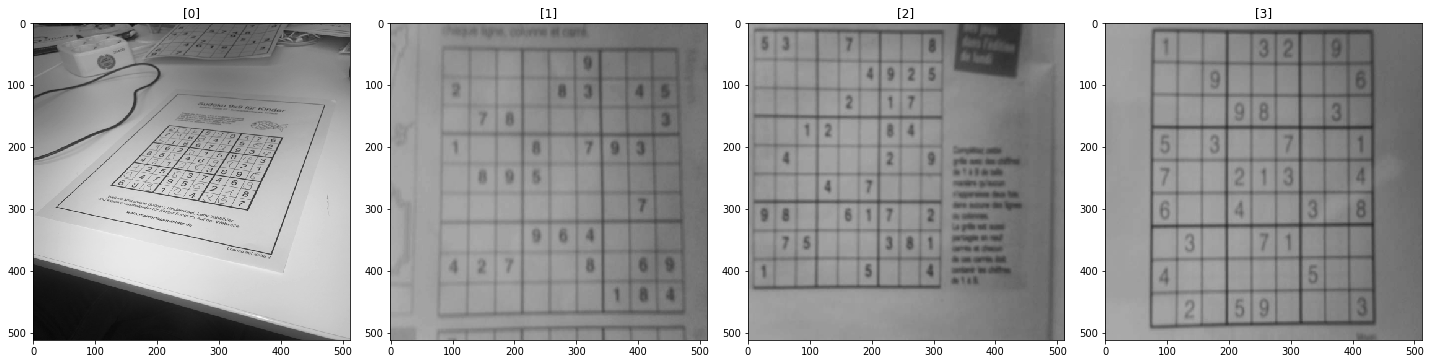

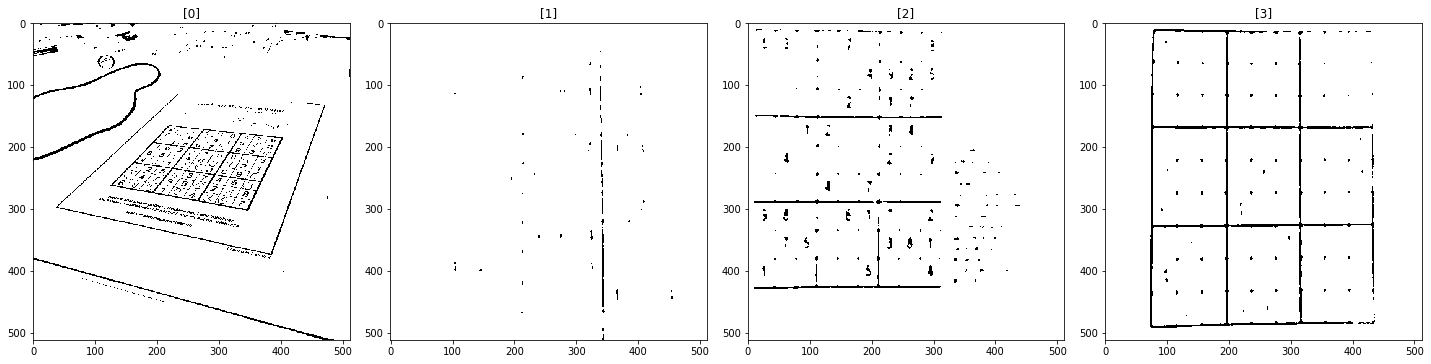

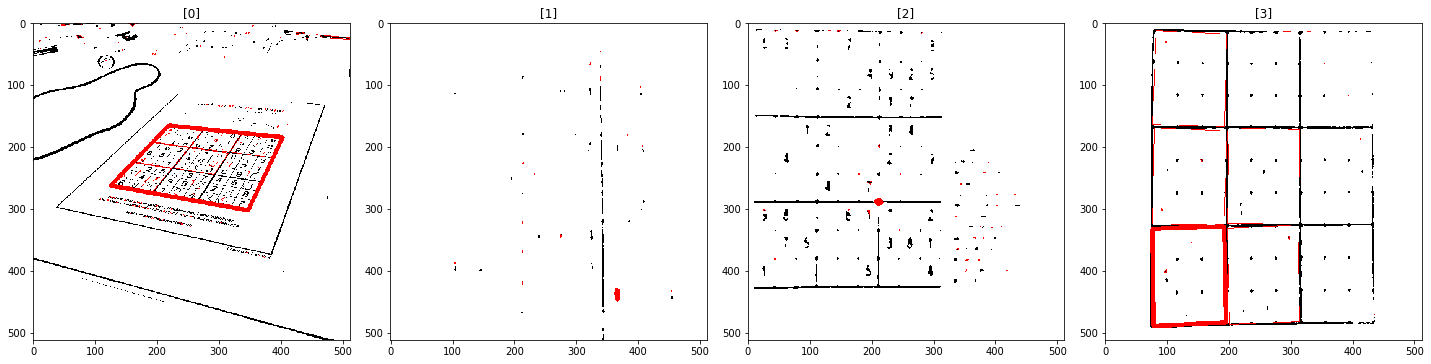

In [44]:
example_images = dataset_bad.sample(n=4)
show_images(example_images["input_image"], rows=1)
show_images(example_images["gray_image"], cmap="gray", rows=1)
show_images(example_images["thresh_image"], cmap="gray", rows=1)
show_images(example_images["contour_image"], rows=1)

# Export

We export the detected Sudoku puzzle's contour as `detected_contour` and `detected_contour_image` for each sample in the `dataset_good` subset.

In [0]:
df = pd.DataFrame({
    "input_filename": dataset_good.index,
    "detected_contour": dataset_good["contour"],
    "detected_contour_image": dataset_good["contour_image"]
}).set_index("input_filename")

In [47]:
df

,detected_contour,detected_contour_image
input_filename,,
./v2_train/image1066.jpg,"[[[34, 139]], [[30, 377]], [[469, 377]], [[454...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
./v2_train/image1087.jpg,"[[[56, 79]], [[51, 374]], [[475, 368]], [[446,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
./v2_train/image204.jpg,"[[[399, 65]], [[97, 72]], [[95, 474]], [[407, ...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
./v2_train/image1075.jpg,"[[[457, 112]], [[58, 117]], [[56, 427]], [[479...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
./v2_train/image1078.jpg,"[[[422, 118]], [[62, 123]], [[53, 395]], [[430...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165410544.jpg,"[[[386, 160]], [[117, 163]], [[94, 373]], [[41...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165338808.jpg,"[[[4, 264]], [[294, 427]], [[478, 238]], [[229...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165329872.jpg,"[[[396, 152]], [[108, 154]], [[86, 379]], [[42...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [0]:
df.to_pickle("./sudoku_detection_output.bz2")

In [0]:
!cp "./sudoku_detection_output.bz2" "./drive/My Drive/sudoku_detection_output.bz2"